In [50]:
from sklearn.neighbors import KernelDensity
from sklearn import datasets, model_selection
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
import pandas as pd 
import seaborn as sn 
from collections import Counter
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Select any dataset corresponding to binary classification problem wih quantitative varia-
bles. Compare the accuracy of Naive Bayes method (with kernel density estimator), Naive
Bayes Method (with Gaussian approximation), Naive Bayes method (with discretization
of quantitative features) and LDA.

In [51]:
EPS = 10e-8

In [52]:
X, Y = datasets.load_breast_cancer(return_X_y=True, as_frame=True)

In [53]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y)

In [54]:
class DiscretizeNB: 
    def __init__(self): 
        pass
    
    def fit(self, x, y): 
        x, y = x.values, y.values
        self.discretizers = [KBinsDiscretizer(n_bins=10, encode='ordinal').fit(x[:, i].reshape(-1, 1))\
                                  for i in range(x.shape[1])]
        x_bins = [self.discretizers[i].transform(x[:, i].reshape(-1, 1)) for i in range(x.shape[1])]
        x_bins = np.concatenate(x_bins, axis=1)
        self.nb = CategoricalNB().fit(x_bins, y)
        return self 
    
    def transform(self, x):
        x = x.values
        x_bins = [self.discretizers[i].transform(x[:, i].reshape(-1, 1)) for i in range(x.shape[1])]
        x_bins = np.concatenate(x_bins, axis=1)
        return self.nb.predict(x_bins)
    
kdnb = DiscretizeNB().fit(x_train, y_train)  
(kdnb.transform(x_test) == y_test).sum() / len(y_test) 

0.9440559440559441

In [55]:
class KernelDensityNB: 
    def __init__(self): 
        pass
    
    def fit(self, x, y): 
        #x_plot_pred = np.exp(KernelDensity(bandwidth=0.3, kernel='epanechnikov')\
        #             .fit(true_x.reshape(-1, 1))\
        #             .score_samples(x_plot))
        x, y = x.values, y.values
        self.density_aproxs = {}
        x_zero = x[y==0]
        self.density_aproxs[0] = [KernelDensity(bandwidth=1, kernel='epanechnikov')\
                                  .fit(x_zero[:,i].reshape(-1, 1))\
                                  for i in range(x_zero.shape[1])]
        x_one = x[y==1]
        self.density_aproxs[1] = [KernelDensity(bandwidth=1, kernel='epanechnikov').fit(x_one[:,i].reshape(-1, 1))\
                                  for i in range(x_one.shape[1])]
        
        self.aprioris = {
            0: (y == 0).sum()/len(y),
            1: (y == 1).sum()/len(y),
        }
        return self
        
    def get_prob(self, values, density_estimator): 
        return np.exp(density_estimator.score_samples(values.reshape(-1, 1)))
    
    def transform(self, x):
        x = x.values
        probabilities_zero = [self.get_prob(x[:,i], self.density_aproxs[0][i]) for i in range(x.shape[1])]
        probabilities_ones = [self.get_prob(x[:,i], self.density_aproxs[1][i]) for i in range(x.shape[1])]
        
        probabilities_zero = np.array(probabilities_zero) + EPS
        probabilities_ones = np.array(probabilities_ones) + EPS
        
        probabilities_zero = probabilities_zero.prod(axis=0)
        probabilities_ones = probabilities_ones.prod(axis=0)
       
        probabilities_zero *= self.aprioris[0]
        probabilities_ones *= self.aprioris[1]
        return (probabilities_zero < probabilities_ones).astype(np.int32)
kdnb = KernelDensityNB().fit(x_train, y_train)  
(kdnb.transform(x_test) == y_test).sum() / len(y_test)

0.9090909090909091

In [56]:
methods = {'Gaussian': GaussianNB, 
             'KernelDensityEstimation': KernelDensityNB, 
             'Discretize': DiscretizeNB, 
            'LDA': LinearDiscriminantAnalysis}

In [57]:
def return_accuracy(method):

    model = method().fit(x_train, y_train)
    try: 
        y_pred_labels = model.predict(x_test)
    except AttributeError:
        y_pred_labels = model.transform(x_test)

    acc = metrics.accuracy_score(y_test, y_pred_labels)
    return acc

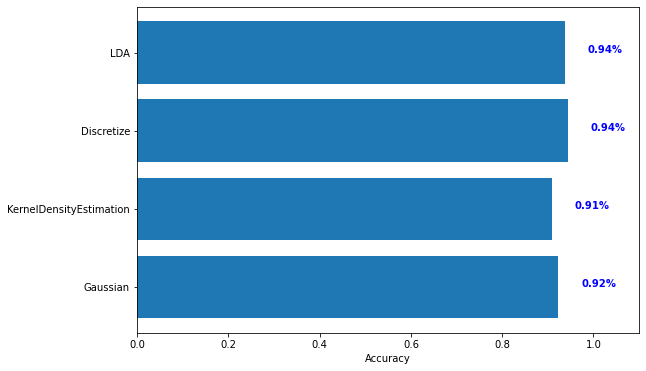

In [58]:
method_names = []
accs = []
for method_name, method in methods.items(): 
    method_names.append(method_name)
    accs.append(return_accuracy(method)) 
fig, ax = plt.subplots(figsize=(9,6))
bars = ax.barh(method_names, accs)
for i, v in enumerate(accs):
    ax.text(v + 0.05, i, str(round(v,2)) + '%', color='blue', fontweight='bold')
_ = ax.set_xlim((0, 1.1))
_ = ax.set_xlabel('Accuracy')